# Step Forward Cross Validation for Bioactivity Prediction

## This Checks to see if the number of molecules in test set is almost the same for all targets

In [2]:
import os
import re

os.chdir('../sfcv/')
from datasplit import SortedStepForwardCV, UnsortedStepForwardCV, ScaffoldSplitCV, RandomSplitCV

os.chdir('../notebook/')

In [3]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("../benchmark/data/processed/target_CHEMBL253-3.Ki.csv")
cv_splitters = {
    "RandomSplit": RandomSplitCV(frac_train=0.9, n_folds=10, seed=69420),
    "ScaffoldSplit": ScaffoldSplitCV(smiles_col='standardized_smiles', n_folds=10,
                                     frac_train=0.9, seed=69420, include_chirality=False),
    "SortedStepForward": SortedStepForwardCV(sorting_col="LogD", ideal=2, n_bins=10, ascending=False),
    "UnsortedStepForward": UnsortedStepForwardCV(n_bins=10, random_state=69420)
}

In [5]:
def add_cv_split_columns(df, cv_splitters):
    df = df.copy()

    # Iterate over each split type
    for split_name, cv_splitter in cv_splitters.items():
        # Iterate over folds
        for fold_idx, (train_idx, test_idx) in enumerate(cv_splitter.split(df), start=1):
            col_name = f"{split_name}_Fold_{fold_idx}"  # Create column name

            # Initialize all entries as "None"
            df[col_name] = None

            # Assign "Train" and "Test" labels
            df.loc[train_idx, col_name] = "Train"
            df.loc[test_idx, col_name] = "Test"

    return df

In [6]:
df_splits = add_cv_split_columns(df, cv_splitters)

/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [7]:
test_set_len = {}

for i in cv_splitters.keys():
    for j in range(1, 10):
        test_set_len[f"{i}_Fold_{j}"] = len(df_splits[f"{i}_Fold_{j}"])

In [8]:
# Prepare a list of records extracting the split type and fold number
records = []
pattern = r'^(.*?)_Fold_(\d+)$'
for key, value in test_set_len.items():
    match = re.match(pattern, key)
    if match:
        split_type = match.group(1)
        fold = int(match.group(2))
        records.append({'Fold': fold, 'Split': split_type, 'Value': value})

# Create a DataFrame from the records
df = pd.DataFrame(records)

# Pivot the DataFrame so that each fold is a row and split types are columns
df_pivot = df.pivot(index='Fold', columns='Split', values='Value').sort_index()

df_pivot

Split,RandomSplit,ScaffoldSplit,SortedStepForward,UnsortedStepForward
Fold,,,,
1,780,780,780,780
2,780,780,780,780
3,780,780,780,780
4,780,780,780,780
5,780,780,780,780
6,780,780,780,780
7,780,780,780,780
8,780,780,780,780
9,780,780,780,780


### Works for one target, let's see if it works for all

In [9]:
ddf = {}

for fname in tqdm(os.listdir('../benchmark/data/processed/'), desc="Processing Splits"):
    if fname.endswith('.csv'):
        df = pd.read_csv(f"../benchmark/data/processed/{fname}")
        ddf[fname[:-4]] = add_cv_split_columns(df, cv_splitters)

Processing Splits:   0%|          | 0/120 [00:00<?, ?it/s]/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Processing Splits:   1%|          | 1/120 [00:00<00:57,  2.06it/s]/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Processing Splits:   2%|▏         | 2/120 [00:00<00:44,  2.68it/s]/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Processing Splits:   2%|▎         | 3/120 [00

In [10]:
ddf['target_CHEMBL237-1.Ki'].columns

Index(['assay_chembl_id', 'compound_chembl_id', 'canonical_smiles',
       'pchembl_value', 'standardized_smiles', 'LogD', 'LogP', 'MCE18',
       'RandomSplit_Fold_1', 'RandomSplit_Fold_2', 'RandomSplit_Fold_3',
       'RandomSplit_Fold_4', 'RandomSplit_Fold_5', 'RandomSplit_Fold_6',
       'RandomSplit_Fold_7', 'RandomSplit_Fold_8', 'RandomSplit_Fold_9',
       'ScaffoldSplit_Fold_1', 'ScaffoldSplit_Fold_2', 'ScaffoldSplit_Fold_3',
       'ScaffoldSplit_Fold_4', 'ScaffoldSplit_Fold_5', 'ScaffoldSplit_Fold_6',
       'ScaffoldSplit_Fold_7', 'ScaffoldSplit_Fold_8', 'ScaffoldSplit_Fold_9',
       'SortedStepForward_Fold_1', 'SortedStepForward_Fold_2',
       'SortedStepForward_Fold_3', 'SortedStepForward_Fold_4',
       'SortedStepForward_Fold_5', 'SortedStepForward_Fold_6',
       'SortedStepForward_Fold_7', 'SortedStepForward_Fold_8',
       'SortedStepForward_Fold_9', 'UnsortedStepForward_Fold_1',
       'UnsortedStepForward_Fold_2', 'UnsortedStepForward_Fold_3',
       'UnsortedStep

In [11]:
# List to collect counts from each DataFrame (each file)
records = []

# Regular expression to match columns like 'RandomSplit_Fold_1'
pattern = r'^(.*?)_Fold_(\d+)$'

# Iterate through each processed DataFrame in ddf.
for fname, df in ddf.items():
    # Loop over columns and find those that match our pattern
    for col in df.columns:
        match = re.match(pattern, col)
        if match:
            split_type = match.group(1)  # e.g. 'RandomSplit'
            fold = int(match.group(2))  # e.g. 1, 2, ...
            count = (df[col] == "Test").sum()
            records.append({
                'File': fname,
                'SplitType': split_type,
                'Fold': fold,
                'TestCompounds': count
            })

# Create a DataFrame from the records.
summary_df = pd.DataFrame(records)

# Optionally, if you want to see the average count per fold across files:
agg_summary = summary_df.groupby(['SplitType', 'Fold'])['TestCompounds'].mean().reset_index()

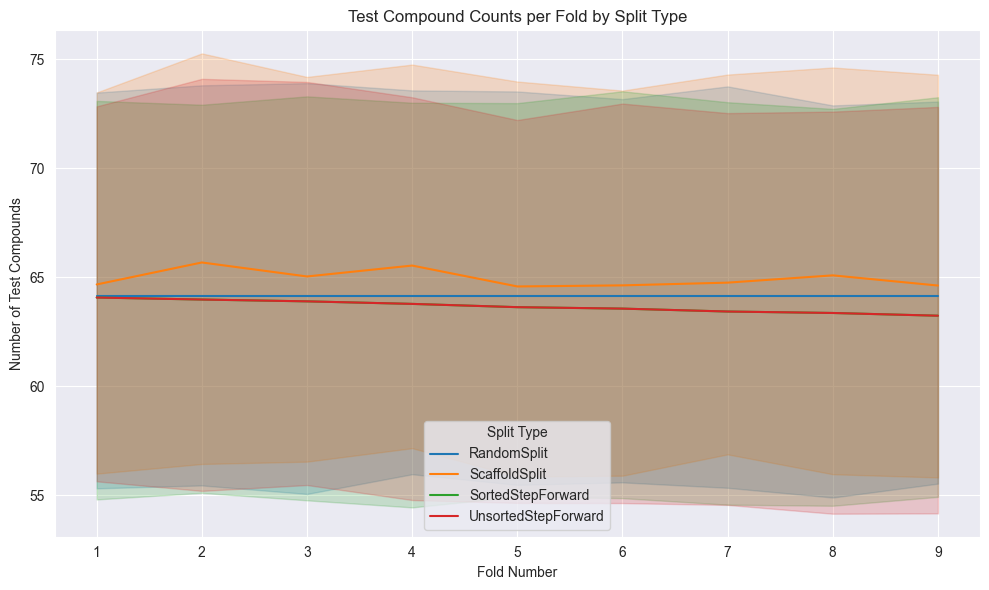

In [12]:
# ----- Plot 1: Line Plot of Test Compound Counts Across Folds -----
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary_df, x="Fold", y="TestCompounds", hue="SplitType")
plt.title("Test Compound Counts per Fold by Split Type")
plt.xlabel("Fold Number")
plt.ylabel("Number of Test Compounds")
plt.legend(title="Split Type")
plt.tight_layout()
plt.show()

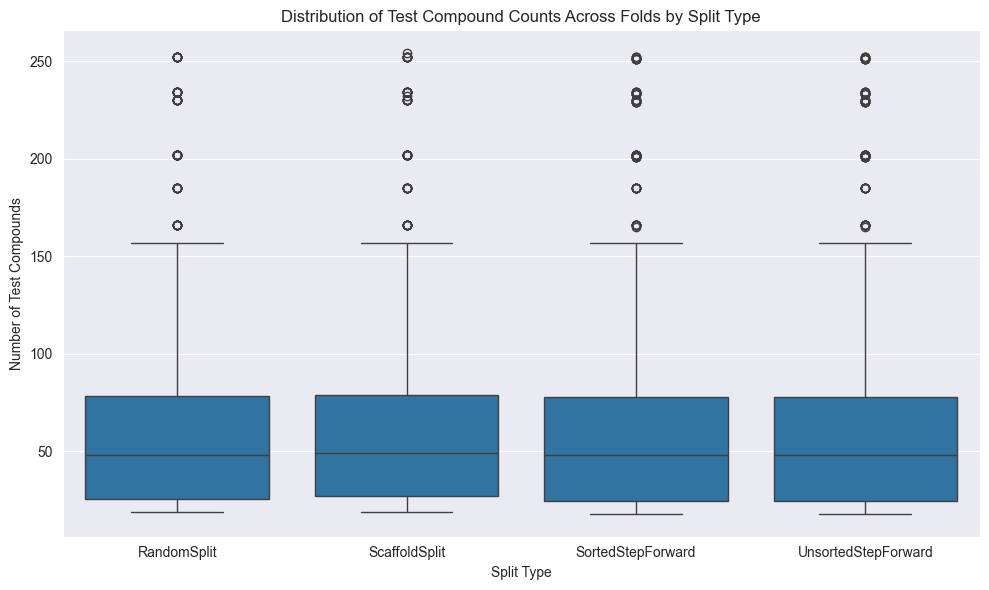

In [13]:
# ----- Plot 2: Box Plot of the Distribution of Test Compound Counts Across Folds -----
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary_df, x="SplitType", y="TestCompounds")
plt.title("Distribution of Test Compound Counts Across Folds by Split Type")
plt.xlabel("Split Type")
plt.ylabel("Number of Test Compounds")
plt.tight_layout()
plt.show()